In [1]:
import pandas as pd
import numpy as np
import ast

from annotation_parser import parse_annotations, sample_action_snippets
from data_visualization import show_stats, plot_poses

PATH_ANNOTATIONS = "../actions.xml"
PATH_FILTERED_ACTIONS = "../filtered_actions.csv"
PATH_FILTERED_ACTIONS_WINDOWED = "../filtered_actions_windowed.csv"

PATH_KEYPOINTS = "../keypoints.csv"
PATH_FINAL_CSV = "../labels.csv"

MINIMUM_DURATION = 4
MINIMUM_ACTION_COUNT = 5
N_SAMPLES_PER_ACTION = 5

## Annotation Parsing / Filtering

In [17]:
df = parse_annotations(PATH_ANNOTATIONS)

df["duration"] = df["end_frame"] - df["start_frame"] + 1
df_actions = df[~df["action"].isin(["ATTACK_PREPARATION", "OTHER_NO_ACTION", "OTHER_RECOVERY"])]

show_stats(df_actions)

action,min,max,mean,std,count
ATTACK_LUNGE,2,11,7.151163,1.482983,172
ATTACK_STOP_CUT,2,15,5.067797,2.016008,59
ATTACK_STEP_CUT,3,8,5.333333,1.314257,45
ATTACK_BEAT,3,10,5.085714,1.597267,35
ATTACK_COUNTER,2,7,4.758621,1.184880,29
ATTACK_RIPOSTE,2,11,5.058824,2.135140,17
ATTACK_FEINT,3,6,4.300000,0.823273,10
ATTACK_FLUNGE,5,11,8.200000,2.201010,10
ATTACK_REMISE,4,10,6.666667,2.338090,6
ATTACK_COMPOUND,5,17,10.000000,6.244998,3


Total Offensive Actions: 389
Total Defensive Actions: 128

Total Actions: 517
Total action classes:  19



In [18]:
df_actions_short = df_actions[df_actions["duration"] < MINIMUM_DURATION]

df_filtered = df_actions[~df_actions["duration"].isin(df_actions_short["duration"])]
df_filtered = df_filtered[df_filtered.groupby("action")["action"].transform("size") >= MINIMUM_ACTION_COUNT]
df_filtered = df_filtered.reset_index(drop=True)

show_stats(df_filtered)

df_filtered["file"] = "/" + df_filtered["source_id"] + "/" + df_filtered["clip_id"]
df_filtered = df_filtered[["file", "fencer", "action", "start_frame", "end_frame"]]

df_filtered.sort_values(by=["file", "fencer", "start_frame"], inplace=True)
df_filtered.to_csv(PATH_FILTERED_ACTIONS, index=False)

action,min,max,mean,std,count
ATTACK_LUNGE,4,11,7.205882,1.401171,170
ATTACK_STOP_CUT,4,15,5.460000,1.940019,50
ATTACK_STEP_CUT,4,8,5.560976,1.141245,41
ATTACK_BEAT,4,10,5.281250,1.528954,32
ATTACK_COUNTER,4,7,5.000000,0.979796,26
ATTACK_RIPOSTE,4,11,5.769231,1.921538,13
ATTACK_FLUNGE,5,11,8.200000,2.201010,10
ATTACK_FEINT,4,6,4.444444,0.726483,9
ATTACK_REMISE,4,10,6.666667,2.338090,6
action,min,max,mean,std,count


Total Offensive Actions: 357
Total Defensive Actions: 118

Total Actions: 475
Total action classes:  14



In [19]:
df_windowed = sample_action_snippets(
    df_filtered, snippet_len=MINIMUM_DURATION, n_samples=N_SAMPLES_PER_ACTION, random_state=42
)

print(df_windowed)
print("")
print(df_windowed["action"].value_counts().to_string())

df_windowed.to_csv(PATH_FILTERED_ACTIONS_WINDOWED, index=False)

                file fencer          action  start_frame  end_frame
0     /1/10_Left.mp4   LEFT    ATTACK_LUNGE           23         26
1     /1/10_Left.mp4  RIGHT    ATTACK_LUNGE           22         25
2     /1/10_Left.mp4  RIGHT    ATTACK_LUNGE           24         27
3     /1/10_Left.mp4  RIGHT    ATTACK_LUNGE           21         24
4     /1/10_Left.mp4  RIGHT    ATTACK_LUNGE           23         26
...              ...    ...             ...          ...        ...
1619   /6/9_Left.mp4  RIGHT    ATTACK_LUNGE           20         23
1620   /6/9_Left.mp4  RIGHT  ATTACK_COUNTER           38         41
1621   /6/9_Left.mp4  RIGHT  ATTACK_COUNTER           39         42
1622   /6/9_Left.mp4  RIGHT  ATTACK_COUNTER           41         44
1623   /6/9_Left.mp4  RIGHT  ATTACK_COUNTER           40         43

[1624 rows x 5 columns]

action
ATTACK_LUNGE             674
DEFENSE_DISTANCE_PULL    287
DEFENSE_POINT_IN_LINE    152
ATTACK_STOP_CUT          113
ATTACK_STEP_CUT          105
ATTACK

## Pose Estimation Filtering / Augmentation

In [2]:
df_keypoints = pd.read_csv(PATH_KEYPOINTS)
print(df_keypoints)

       Unnamed: 0    conf_0    conf_1   conf_10   conf_11   conf_12   conf_13  \
0               0  0.464459  0.571280  0.678688  0.988575  0.972946  0.976669   
1               1  0.817640  0.367547  0.976865  0.993006  0.997376  0.980778   
2               2  0.638639  0.707833  0.786569  0.992743  0.984247  0.986711   
3               3  0.852675  0.457623  0.984824  0.994814  0.997683  0.987082   
4               4  0.881222  0.889724  0.914548  0.995318  0.991397  0.962191   
...           ...       ...       ...       ...       ...       ...       ...   
16245        3037  0.666626  0.365190  0.922924  0.997794  0.998020  0.995435   
16246        3038  0.084836  0.017512  0.891996  0.997356  0.998623  0.984317   
16247        3039  0.922641  0.834707  0.974010  0.998561  0.998577  0.997403   
16248        3040  0.027762  0.011156  0.652438  0.995529  0.995885  0.985711   
16249        3041  0.749446  0.618751  0.973928  0.998549  0.998359  0.996950   

        conf_14   conf_15  

In [3]:
def merge_cols(df, old_col_prefix, new_col_name):
    keypoint_cols = [old_col_prefix + str(i) for i in range(0, 17)]
    
    df[new_col_name] = df[keypoint_cols].values.tolist()
    df = df.drop(columns=keypoint_cols)

    df[new_col_name] = df[new_col_name].apply(
        lambda kp_list: [ast.literal_eval(kp) if isinstance(kp, str) else kp for kp in kp_list]
    )

    return df

df_keypoints = merge_cols(df_keypoints, "keypoint_", "keypoints")
df_keypoints = merge_cols(df_keypoints, "conf_", "confidences")

print(df_keypoints)

       Unnamed: 0            file  frame label  \
0               0  /1/10_Left.mp4      0  Left   
1               1  /1/10_Left.mp4      0  Left   
2               2  /1/10_Left.mp4      1  Left   
3               3  /1/10_Left.mp4      1  Left   
4               4  /1/10_Left.mp4      2  Left   
...           ...             ...    ...   ...   
16245        3037   /6/9_Left.mp4     42  Left   
16246        3038   /6/9_Left.mp4     43  Left   
16247        3039   /6/9_Left.mp4     43  Left   
16248        3040   /6/9_Left.mp4     44  Left   
16249        3041   /6/9_Left.mp4     44  Left   

                                               keypoints  \
0      [(1253.13427734375, 604.66943359375), (1255.89...   
1      [(657.8931274414062, 607.7868041992188), (659....   
2      [(1254.5994873046875, 605.628173828125), (1258...   
3      [(656.7911987304688, 608.1182250976562), (658....   
4      [(1255.2308349609375, 599.4973754882812), (125...   
...                                    

In [4]:
df_keypoints["fencer"] = np.where(df_keypoints.index % 2 == 0, "RIGHT", "LEFT")

df_keypoints = df_keypoints[["file", "fencer", "frame", "keypoints", "confidences"]]
df_keypoints.sort_values(by=["file", "fencer", "frame"], inplace=True)
df_keypoints = df_keypoints.reset_index(drop=True)

print(df_keypoints)

                 file fencer  frame  \
0      /1/10_Left.mp4   LEFT      0   
1      /1/10_Left.mp4   LEFT      1   
2      /1/10_Left.mp4   LEFT      2   
3      /1/10_Left.mp4   LEFT      3   
4      /1/10_Left.mp4   LEFT      4   
...               ...    ...    ...   
16245   /6/9_Left.mp4  RIGHT     40   
16246   /6/9_Left.mp4  RIGHT     41   
16247   /6/9_Left.mp4  RIGHT     42   
16248   /6/9_Left.mp4  RIGHT     43   
16249   /6/9_Left.mp4  RIGHT     44   

                                               keypoints  \
0      [(657.8931274414062, 607.7868041992188), (659....   
1      [(656.7911987304688, 608.1182250976562), (658....   
2      [(654.1593017578125, 606.0661010742188), (657....   
3      [(654.2938232421875, 605.9837036132812), (657....   
4      [(657.7745361328125, 605.797607421875), (661.6...   
...                                                  ...   
16245  [(842.9161987304688, 580.9956665039062), (839....   
16246  [(828.2440795898438, 575.3505249023438), (82

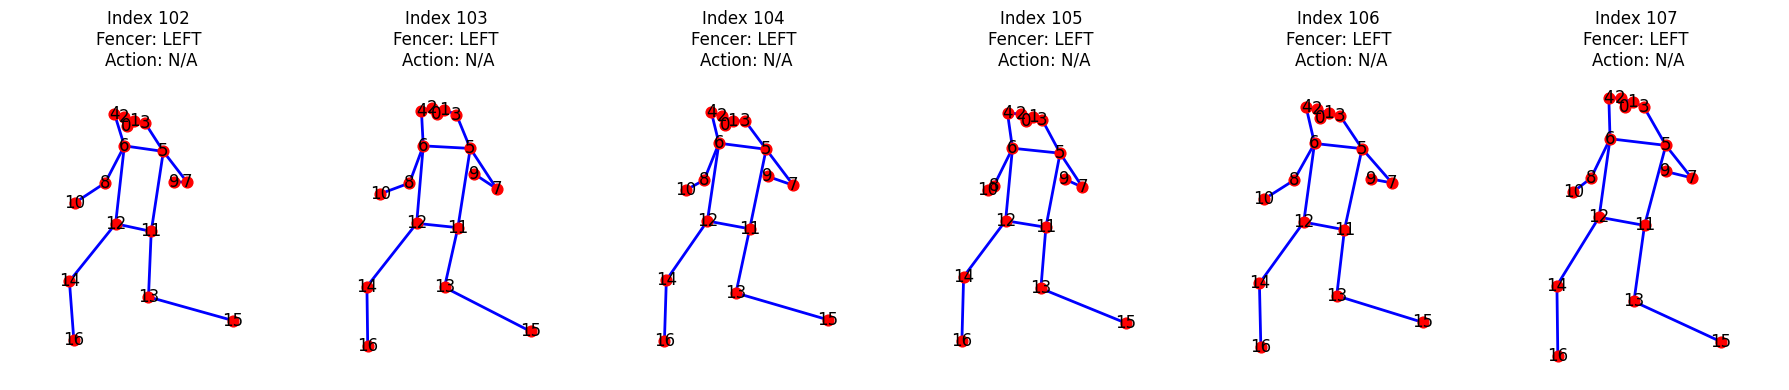

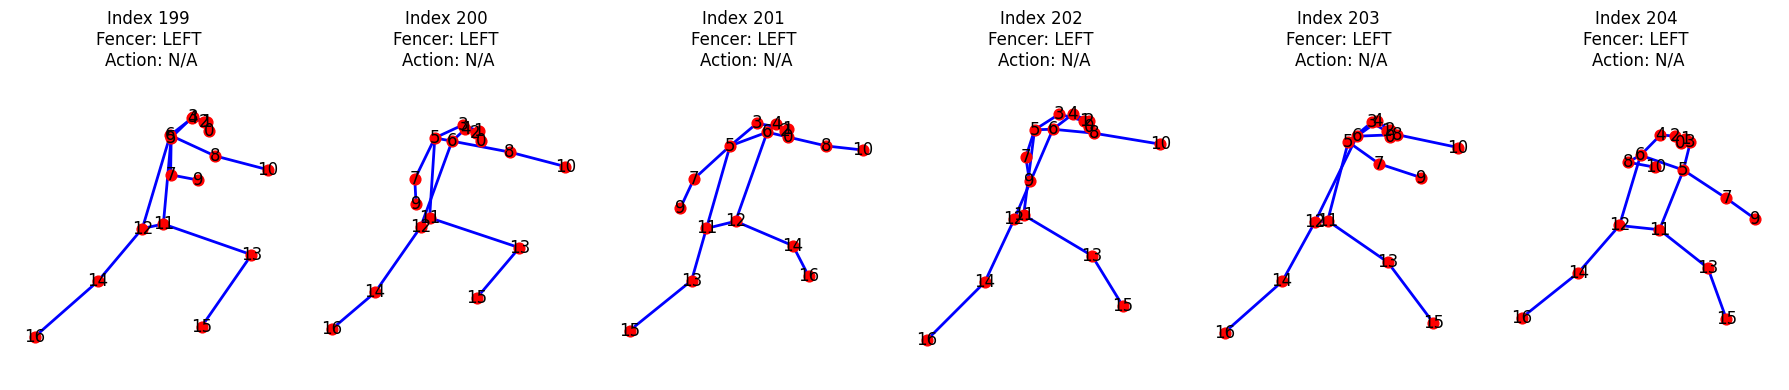

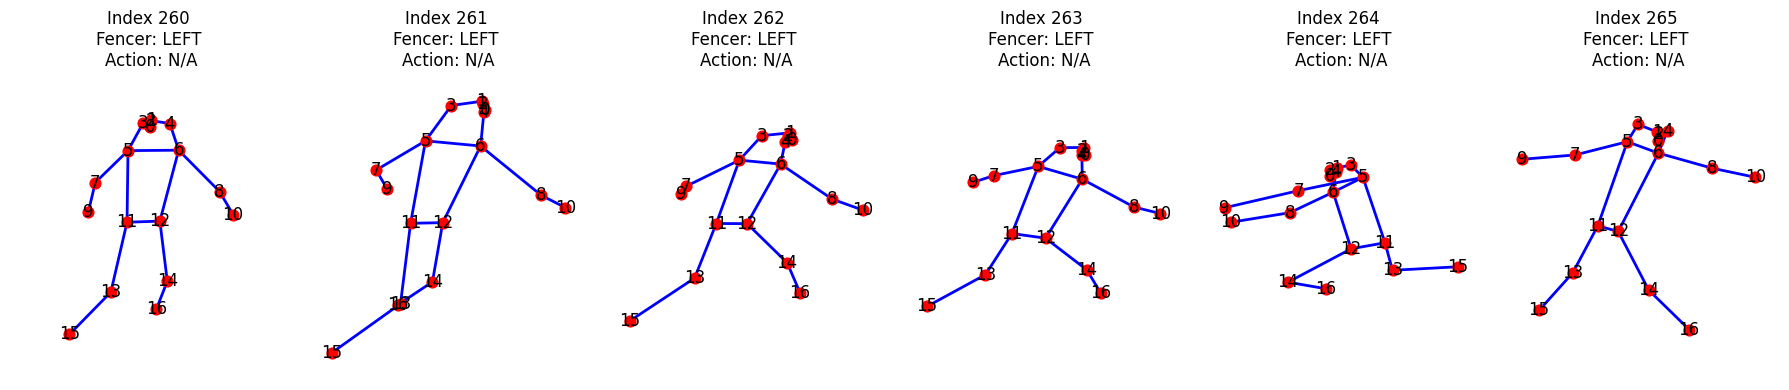

In [ ]:
plot_poses(df_keypoints, 102, 107, 6)   # /1/11_Left.mp4,   LEFT,   ATTACK_LUNGE,       60,65
plot_poses(df_keypoints, 199, 204, 6)   # /1/12_Right.mp4,  LEFT,   ATTACK_STEP_CUT,    31,36
plot_poses(df_keypoints, 260, 265, 6)   # /1/13_Left.mp4,   LEFT,   ATTACK_LUNGE,       16,21

In [7]:
df_filtered = pd.read_csv(PATH_FILTERED_ACTIONS)

df_merged = df_keypoints.merge(df_filtered, on=["file", "fencer"], how="left")
df_merged = df_merged[
    (df_merged["frame"] >= df_merged["start_frame"]) &
    (df_merged["frame"] <= df_merged["end_frame"])
]

df_merged = df_merged[["file", "fencer", "action", "frame", "keypoints", "confidences"]].reset_index(drop=True)
print(df_merged)

                file fencer          action  frame  \
0     /1/10_Left.mp4   LEFT    ATTACK_LUNGE     24   
1     /1/10_Left.mp4   LEFT    ATTACK_LUNGE     26   
2     /1/10_Left.mp4  RIGHT    ATTACK_LUNGE     21   
3     /1/10_Left.mp4  RIGHT    ATTACK_LUNGE     23   
4     /1/10_Left.mp4  RIGHT    ATTACK_LUNGE     25   
...              ...    ...             ...    ...   
4032   /6/9_Left.mp4  RIGHT  ATTACK_COUNTER     40   
4033   /6/9_Left.mp4  RIGHT  ATTACK_COUNTER     41   
4034   /6/9_Left.mp4  RIGHT  ATTACK_COUNTER     42   
4035   /6/9_Left.mp4  RIGHT  ATTACK_COUNTER     43   
4036   /6/9_Left.mp4  RIGHT  ATTACK_COUNTER     44   

                                              keypoints  \
0     [(1138.376953125, 638.0005493164062), (1141.70...   
1     [(1063.94921875, 636.8140869140625), (1064.913...   
2     [(778.1942138671875, 644.463134765625), (791.6...   
3     [(1096.138427734375, 626.57080078125), (1095.2...   
4     [(808.6652221679688, 635.3206787109375), (834.... 

In [ ]:
# Confidence stats, drop if too loo, use linerar interpolation to fill gaps, or duplicate nearest neighbor, drop if whole row bad